In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from geopy.point import Point
from geopy.geocoders import Nominatim
import requests
from bs4 import BeautifulSoup

In [4]:
# also importing functions from our module
from functions_cleaning import count_na, to_point, get_geo_feature, replace_exceptions, print_city_unique, clean_city_col, get_table_bs4, code_reverse_feature

In [5]:
os.getcwd()

'/Users/jbrable/Documents/ENSAE_2AD/S1/python/UFO'

In [4]:
df = pd.read_csv("data/ufo_sightings_scrubbed.csv")

/var/folders/j3/7p5c8ygd7yg6bgkb6r90ddhm0000gn/T/ipykernel_34177/2315484744.py:1: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/ufo_sightings_scrubbed.csv")


In [5]:
df.head()

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
0,1949-10-10 20:30:00,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,2004-04-27,29.8830556,-97.941111
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.38421,-98.581082
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.2,-2.916667
3,1956-10-10 21:00:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,2004-01-17,28.9783333,-96.645833
4,1960-10-10 20:00:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,2004-01-22,21.4180556,-157.803611


In [6]:
df.shape

(80332, 11)

# 1) Cleaning data

## 1.1) Column names

In [7]:
df.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude '],
      dtype='object')

We notice a 2 issues, that is, the 'longitude' column label is mispelled : it contains a blank space at the end of the string. The other issue is that some other columns names are not very clean: for example, they contains spaces or parenthesis, which can be quite disturbing later:

In [8]:
df = df.rename(columns = {'date posted': 'date_posted'})

In [9]:
df.columns = df.columns.str.replace(' ', '', regex = True) # removing spaces
df.columns = df.columns.str.replace('(\/)|(\()', '_', regex = True)
df.columns = df.columns.str.replace('(\))', '', regex = True)
#df.columns

In [10]:
df.columns

Index(['datetime', 'city', 'state', 'country', 'shape', 'duration_seconds',
       'duration_hours_min', 'comments', 'date_posted', 'latitude',
       'longitude'],
      dtype='object')

In [11]:
df.dtypes

datetime               object
city                   object
state                  object
country                object
shape                  object
duration_seconds       object
duration_hours_min     object
comments               object
date_posted            object
latitude               object
longitude             float64
dtype: object

We also notice that 'longitude' column is a type float, which is pretty logical, whereas 'latitude' column if typed as an object : why ? Let's check it out:

In [12]:
df[df['latitude'].astype(str).str.contains('[a-zA-Z]')]

,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date_posted,latitude,longitude
43782,1974-05-22 05:30:00,mescalero indian reservation,nm,NaN,rectangle,180,two hours,Huge rectangular object emmitting intense whit...,2012-04-18,33q.200088,-105.624152


We see that this problem is probably due to a typo: the corresponding latitude for 'mescalero indian reservation' contains a letter ('q'). Since this issue only concerns a single row, we can check the real latitude of this place on the Internet (if there were too many rows, we would have chosen another soluton). It turns out that the real latitude is 33.2 so the error was indeed the result of a typo, so we can remove the misplaced letter:

In [13]:
df['latitude'] = pd.to_numeric(df['latitude'].astype(str).str.extract('(\d+.\d+|\d+)', expand = False))
#df.dtypes #now both of the 'latitude' and 'longitude' columns have the right type!

We have the same issue with the "duration" column, so let's fix it:

In [14]:
df["duration_seconds"] = pd.to_numeric(df['duration_seconds'].astype(str).str.extract('(\d+.\d+|\d+)', expand = False))

## 1.2) Handling NaN values

In [15]:
count_na(df)

,sum,perc
country,9670,12.037544
state,5797,7.216302
shape,1932,2.405019
comments,15,0.018673
datetime,0,0.000000
city,0,0.000000
duration_seconds,0,0.000000
duration_hours_min,0,0.000000
date_posted,0,0.000000
latitude,0,0.000000


We notice that there are quite a lot of NaN values in both "country" and "state" columns. Let's see a few rows that are concerned by this phenomenon:

In [16]:
df.query('country.isna() | state.isna()', engine = 'python')

,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date_posted,latitude,longitude
1,1949-10-10 21:00:00,lackland afb,tx,NaN,light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082
2,1955-10-10 17:00:00,chester (uk/england),NaN,gb,circle,20.0,20 seconds,Green/Orange circular disc over Chester&#44 En...,2008-01-21,53.200000,-2.916667
6,1965-10-10 21:00:00,penarth (uk/wales),NaN,gb,circle,180.0,about 3 mins,penarth uk circle 3mins stayed 30ft above m...,2006-02-14,51.434722,-3.180000
18,1973-10-10 23:00:00,bermuda nas,NaN,NaN,light,20.0,20 sec.,saw fast moving blip on the radar scope thin w...,2002-01-11,32.364167,-64.678611
20,1974-10-10 21:30:00,cardiff (uk/wales),NaN,gb,disk,1200.0,20 minutes,back in 1974 I was 19 at the time and lived i...,2007-02-01,51.500000,-3.200000
...,...,...,...,...,...,...,...,...,...,...,...
80254,2009-09-09 21:15:00,nottinghamshire (uk/england),NaN,gb,fireball,600.0,10 mins,resembled orange flame imagine a transparent h...,2009-12-12,53.166667,-1.000000
80255,2009-09-09 21:38:00,kaiserlautern (germany),NaN,de,light,40.0,about 40 seconds,2 white lights over Kaiserslautern&#44 ramstei...,2009-12-12,49.450000,7.750000
80319,2013-09-09 20:15:00,clifton,nj,NaN,other,3600.0,~1hr+,Luminous line seen in New Jersey sky.,2013-09-30,40.858433,-74.163755
80322,2013-09-09 21:00:00,aleksandrow (poland),NaN,NaN,light,15.0,15 seconds,Two points of light following one another in a...,2013-09-30,50.465843,22.891814


* For the "state" column, the problem is likely due to the fact that a "state" is commonly used in the US or in Canada, but not in other countries. Thus, we won't touch at this column for the moment.

### 1.2.1 Cleaning "country" column

In a first approach, we decided to fill NaN values in the "country" column by searching the corresponding country of the given latitude and longitude (this two columns are always filled). To do so, we will use the "geopy" library (geopy is actually a client), which allows to find the country, based on the geographic coordinates.

In [17]:
# connecting to the service
geolocator = Nominatim(user_agent="begining")

In [18]:
# partioning our df between missing values and non-missing values
df1 = df[df['country'].isna()].reset_index(drop=False)
df2 = df[~df['country'].isna()]

In [19]:
df1.shape[0] + df2.shape[0] == df.shape[0]

True

In [20]:
# getting a full coordinate system for each row, based on the latitude and longitude column
df1['coords'] = [to_point(x, y) for x, y in zip(df1['latitude'], df1['longitude'])]

We will apply our functions "get_geo_feature" to obtain the country code for each row where the country is missing. **This step might be time costly (approx. 1h30).**

In [21]:
df1['country'] = np.vectorize(get_geo_feature)(coord=df1['coords'].values,
                                               feature='country_code',
                                              geolocator=geolocator).tolist()

In [22]:
df1['country'] = np.where(df1['country']=='nan', np.nan, df1['country'])

In [23]:
df1['country'].isna().sum()

435

In [24]:
df1 = df1.drop(['coords', 'index'], axis=1)

The observations where the country was (formerly) missing must be combined with those where the country was known. Thus, we have to binds the rows of the two dataframes in order to get al the observations reunited:

In [25]:
df = pd.concat([df1, df2], ignore_index=True, axis=0)

In [26]:
df.shape # we got back the shape of the begnining

(80332, 11)

In a second approach, we will use the information that we have in the "city" column: indeed we notice that there is some potential information about the country inside this column (see above)!! But sometimes, this information is not relevant, for example if we look at the tail of the dataframe above, "hollyridge" is clearny not a country, but a US state! We have to make sure that if there is additionnal information in the "city", this information is actually a country!

The easiest way to do this is to use web-scraping to get the list of all countries with the corresponding country codes (country codes will be useful to standardize the country column):

In [23]:
table = get_table_bs4(URL="https://www.iban.com/country-codes")
#print(table)

table table-bordered downloads tablesorter


In [24]:
countries_id = code_reverse_feature(table, "Country", 0, 1)

print(countries_id.shape)
display(countries_id.head())

(249, 2)


,Country,Alpha-2 code
0,afghanistan,af
1,åland islands,ax
2,albania,al
3,algeria,dz
4,american samoa,as


Now that we have a list of all the countries in the world, we can first standardize the country column by converting the country codes into country names, for non-missing country values in our dataframe. To do so, we just have to create a dictionnary with both the country-code and the corresponding country name, and then map it to the "country" column:

In [43]:
countries_dict = dict(zip(countries_id['Alpha-2 code'], countries_id['Country']))

In [44]:
df['country'] = df['country'].replace(countries_dict)

Finally, we can easily detect if there is some informative content in the "city" column for each row, by comparing it  with the list of the countries that we previously built. In order to perform this step, we will have to use regex: first, we create a "large pattern" with our country Series:

In [45]:
pattern_countries = '('+ '|'.join(countries_id['Country'].apply(lambda x: re.sub(r'\((.*)\)', '', x))) +')'
#pattern_countries

Then, we match this pattern with the "city" column, for each row (NB: str.extract method is vectorized):

In [46]:
df['test'] = df['city'].str.extract(pattern_countries)[0]

In [47]:
df.country.isna().sum()

435

Then, we can replace the values of the country that are missing by the values obtained with our method:

In [48]:
df['country'] = np.where(df['country'].isna(), df['test'], df['country'])

In [49]:
print(df[df['country'].isna()].shape)
print(df[df['test'].isna()].shape)
print(df[df['country'].isna() & df['test'].isna()].shape)

(85, 12)
(73154, 12)
(85, 12)


We see that our method allowed to reduce the number of NaN values in the "country" column. But there is still some missing values: let's check those rows to see the issue:

In [50]:
pd.set_option('display.max_rows', None)

print(df[df['test'].isna() & df['country'].isna()]['city'].value_counts().sort_index())

pd.reset_option('display.max_rows')

armidale (australi)                                             1
atlantic ocean                                                 11
atlantic ocean (at sea)                                         1
atlantic ocean (between nassau&#44 bahamas&#44 and florida)     1
atlantic ocean (between san juan and u.s. virgin isl.)          1
atlantic ocean (cv-67 u.s.navy)                                 1
atlantic ocean (in flight)                                      2
atlantic ocean (inflight)                                       1
atlantic ocean (mid-atlantic)                                   1
atlantic ocean (middle)                                         1
atlantic ocean (off africa)                                     1
atlantic ocean (on cruise ship)                                 1
atlantic ocean (troopship/ uss rose)                            1
atlantic ocean (virgin islands)                                 1
bogor                                                           1
broken hil

We notice 2 main issues:
* the "city" column may contain a sea or ocean name. For these rows, we are going to define the country as "sea" or "ocean";
* there is some issues with country names such as "brazil", "bolivia", "australia". For what is possible and easy, we will replace the country names by hand. But for the remaining rows (there aren't many), we will put a NaN value.

Hence, we will use our functions "replace_exceptions" in order to replace these exceptions.

In [51]:
df[(df['country'].isna())].shape

(85, 12)

In [54]:
df['country'] = np.where((df['test'].isna() & df['country'].isna()), df['city'].apply(replace_exceptions), df['country'])

In [55]:
df[(df['country'].isna())].shape

(20, 12)

For the country name that are still missing, we decided to delete them, because they are very few of them, we decided to let them as NaN values.

In [8]:
canada = ['sk', 'qc', 'pr', 'pq', 'on', 'ns', 'nf', 'bf', 'bc', 'ab']
df.loc[df["state"].isin(canada), "country"] = "canada"

## 1.3) Cleaning 'city' column

If we have a closer look to this column, we see that the values are not harmonized and can be confusing and noisy:

In [56]:
df.query("city.str.contains('\(') | city.str.contains('\)')", engine='python')

,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date_posted,latitude,longitude,test
2,1979-10-10 22:00:00,saddle lake (canada),ab,canada,triangle,270.0,4.5 or more min.,Lights far above&#44 that glance; then flee f...,2005-01-19,53.970571,-111.689885,canada
3,1982-10-10 07:00:00,gisborne (new zealand),NaN,new zealand,disk,120.0,2min,gisborne nz 1982 wainui beach to sponge bay,2002-01-11,38.662334,178.017649,new zealand
6,1993-10-10 03:00:00,zlatoust (russia),NaN,russian federation (the),sphere,1200.0,20 minutes,I woke up at night and looked out the window n...,2004-12-14,55.183333,59.650000,NaN
8,1996-10-10 20:00:00,lake macquarie (nsw&#44 australia),NaN,australia,light,300.0,5 min,RED LIGHT WITH OTHER RED FLASHING LIGHT&#44 ON...,1999-05-24,33.093373,151.588982,australia
10,1999-10-10 22:30:00,casey key (north end of),fl,united states of america (the),triangle,120.0,several minutes,A large trianglual shaped craft flew from hori...,2002-09-19,27.150053,-82.480653,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
80298,2012-09-09 14:00:00,pictou (canada),ns,canada,disk,600.0,10 minutes,Spotted a object over the town&#39s business d...,2012-09-24,45.666667,-62.700000,canada
80311,2012-09-09 21:00:00,new york city (brooklyn),ny,united states of america (the),light,1290.0,21:30,Glowing&#44 circular lights visible in the clo...,2012-09-24,40.714167,-74.006389,NaN
80317,2013-09-09 01:50:00,buffalo (west of; on highway 90 west),ny,united states of america (the),triangle,180.0,3 minutes,Massive Flat Black triangle with 3 red lights.,2013-09-30,42.886389,-78.878611,NaN
80321,2013-09-09 13:10:00,calmar (canada),ab,canada,unknown,90.0,45-90 seconds,Fastest dot I have ever seen in the sky&#33,2013-09-09,53.250000,-113.783333,canada


We have to remove all parenthesis from this column. Then, we have to harmonize the city name; and we will eventually standardize this column by capitalizing the city names and to remove white spaces for a single-word-city.

In [64]:
df = clean_city_col(df=df)
# the number of differents city values at each step of the processing is decreasing: perfect

19900
18386
18290
18290


Our processing of the city column has resulted in the harmonization and standardization of city names. This achievement will be very convenient for the interactive map that we are going to create and also for an in-depth statistical analysis.

## 1.4) Cleaning "shape" column

In [67]:
df["shape"].value_counts()

light        16565
triangle      7865
circle        7608
fireball      6208
other         5649
unknown       5584
sphere        5387
disk          5213
oval          3733
formation     2457
cigar         2057
changing      1962
flash         1328
rectangle     1297
cylinder      1283
diamond       1178
chevron        952
egg            759
teardrop       750
cone           316
cross          233
delta            7
crescent         2
round            2
dome             1
pyramid          1
flare            1
hexagon          1
changed          1
Name: shape, dtype: int64

## 1.4) Cleaning "datetime" column

Here we just want to standardize the format of the date. No missing values. Other changes will be done for in the webapp.

In [68]:
format='%Y-%m-%d %H:%M:%S'
df['datetime'] = pd.to_datetime(df['datetime'], format=format)

## 1.5) Cleaning "state" column

Here we just need to replace the US states codes by their names. We will use again webscrapping to match the alpha code of each state with its full name:

In [25]:
table = get_table_bs4(URL="https://www23.statcan.gc.ca/imdb/p3VD.pl?Function=getVD&TVD=53971")
#print(table)

table table-bordered responsive-utilities table-hover table-condensed mrgn-bttm-0


In [28]:
states_id = code_reverse_feature(table, "State", 0, 2, True, "fips")
#states_id

In [116]:
df["state"].isna().sum()

5797

In [117]:
df[df["country"] == "united states of america (the)"]["state"].isna().sum()

113

In [123]:
states_dict = dict(zip(states_id['Alpha-2 code'], states_id['State']))
df['state'] = df['state'].replace(states_dict)

In [124]:
df["state"].isna().sum()

5797

In [125]:
df[df["country"] == "united states of america (the)"]["state"].isna().sum()

113

In [126]:
df.head()

,datetime,city,state,country,shape,duration_seconds,duration_hours_min,comments,date_posted,latitude,longitude,test
0,1949-10-10 21:00:00,Lackland Afb,texas,united states of america (the),light,7200.0,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,2005-12-16,29.384210,-98.581082,texas
1,1973-10-10 23:00:00,Bermuda Nas,NaN,bermuda,light,20.0,20 sec.,saw fast moving blip on the radar scope thin w...,2002-01-11,32.364167,-64.678611,NaN
2,1979-10-10 22:00:00,Saddle Lake,ab,canada,triangle,270.0,4.5 or more min.,Lights far above&#44 that glance; then flee f...,2005-01-19,53.970571,-111.689885,ab
3,1982-10-10 07:00:00,Gisborne,NaN,new zealand,disk,120.0,2min,gisborne nz 1982 wainui beach to sponge bay,2002-01-11,38.662334,178.017649,NaN
4,1986-10-10 20:00:00,Holmespawling,new york,united states of america (the),chevron,180.0,3 minutes,Football Field Sized Chevron with bright white...,2007-10-08,41.523427,-73.646795,new york


It seems to have worked!

# 2) Data Exportation

In [129]:
count_na(df)

,sum,perc
state,5797,7.216302
shape,1932,2.405019
country,20,0.024897
comments,15,0.018673
datetime,0,0.000000
city,0,0.000000
duration_seconds,0,0.000000
duration_hours_min,0,0.000000
date_posted,0,0.000000
latitude,0,0.000000


Since we have clean our data, we should export it into a new .csv file, so as to facilitate oru collaborative work:

In [9]:
df.to_csv("data/ufo_sightings_clean.csv", index = False)

This step was useful, because since we have run a very time costly function above, we don't have to re-run the whole code every time we launch the notebook. Hence, we can import our cleaned data here:

In [10]:
df = pd.read_csv("data/ufo_sightings_clean.csv")

# 3) WordCloud

In order to visualize and leverage the "comments" column, we decided to use a NLP technique: create a wordcloud.

In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from wc_functions import word_count, mywc, display_wc

Let's take a look at the "comments" column:

In [12]:
df["comments"]

0        1949 Lackland AFB&#44 TX.  Lights racing acros...
1        saw fast moving blip on the radar scope thin w...
2        Lights far above&#44  that glance; then flee f...
3              gisborne nz 1982 wainui beach to sponge bay
4        Football Field Sized Chevron with bright white...
                               ...                        
80327    Round from the distance/slowly changing colors...
80328    Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...
80329                                         Napa UFO&#44
80330    Saw a five gold lit cicular craft moving fastl...
80331    2 witnesses 2  miles apart&#44 Red &amp; White...
Name: comments, Length: 80332, dtype: object

It is indeed very messy. Firstly, we need to define what we call "stop words", i.e. words that interfere with the true meaning of a given word string. Let's see which ones are already given by the wordcloud package:

In [13]:
print(STOPWORDS)

{"shan't", 'those', 'we', 'them', 'an', 'by', 'it', 'were', 'me', 'am', "didn't", 'else', 'himself', 'itself', "doesn't", "they're", 'she', 'if', 'he', 'be', 'about', 'just', 'when', 'very', 'few', "hadn't", 'off', 'doing', 'ours', "that's", 'has', "i'd", 'have', 'not', 'cannot', "couldn't", 'or', "weren't", 'but', "here's", 'since', 'their', "we'll", "where's", 'further', 'i', "why's", "aren't", 'only', 'into', "i'm", 'against', "don't", 'do', 'each', 'ought', 'is', 'any', "they'll", "we've", 'yourselves', 'whom', 'too', 'above', 'my', 'ourselves', "he'll", 'k', 'so', 'over', "she's", 'would', 'all', 'should', 'which', 'are', 'however', 'then', 'theirs', "i'll", "they've", 'yours', 'like', 'through', 'of', 'from', 'this', 'www', 'can', 'what', 'other', "won't", 'did', 'more', 'with', "can't", 'our', 'same', 'your', 'you', 'while', 'up', 'out', 'both', 'own', "she'll", 'these', 'myself', "how's", "you'd", 'until', 'get', "you've", 'between', "he's", 'a', 'below', 'him', 'its', 'the', '

In [14]:
# Adding a few ones
MYSTOPWORDS = STOPWORDS.update(['39s', 'quot'])

Now, we are going to check (or at least try to) the most common words in the comments.

In [15]:
all_comments = " ".join(str(s) for s in df.comments) # joining comments all together
wc = word_count(all_comments) # counting occurrence for each single word
word_counts = Counter(all_comments.split(" ")) # then splitting the raw string into single words
word_counts.most_common(20)

[('the', 33209),
 ('in', 31967),
 ('a', 27294),
 ('and', 24842),
 ('', 21568),
 ('of', 20267),
 ('to', 15501),
 ('light', 14131),
 ('lights', 13545),
 ('over', 12973),
 ('I', 12782),
 ('was', 11668),
 ('object', 11663),
 ('sky', 10534),
 ('at', 10300),
 ('with', 9551),
 ('on', 8257),
 ('bright', 8174),
 ('moving', 8128),
 ('from', 7034)]

For the moment, it is not that good: there are still a lot of irrelevant words. Let's remove some, and see what we obtain next:

In [16]:
stopwords2 = ['', '3', 'my', 'A', 'no', 'on', 'the', 'of', 'and', 'is','to','in','a','from','by','that', 'with', 'this', 'as', 'an', 'are','its', 'at', 'for', ':', 'I', 'it', 'over', 'was', 'then']
words_without_stopwords = [word for word in all_comments.split(" ") if word not in stopwords2]
most_commons = Counter(words_without_stopwords).most_common(20)
most_commons

[('light', 14131),
 ('lights', 13545),
 ('object', 11663),
 ('sky', 10534),
 ('bright', 8174),
 ('moving', 8128),
 ('white', 5665),
 ('saw', 5554),
 ('shaped', 5337),
 ('seen', 5083),
 ('orange', 4909),
 ('very', 4770),
 ('red', 4671),
 ('like', 4289),
 ('flying', 4229),
 ('craft', 3973),
 ('Bright', 3927),
 ('sky.', 3608),
 ('across', 3458),
 ('were', 3409)]

It's better! However, we can do better because some words are very similar. A way to do so is to do a wordcloud from "wordcloud" package. The corresponding script is in the module "wc_function.py". We can check the output on the whole dataframe:

In [17]:
wordcloud = mywc(df=df, col="comments", words_update=['39s', 'quot'])

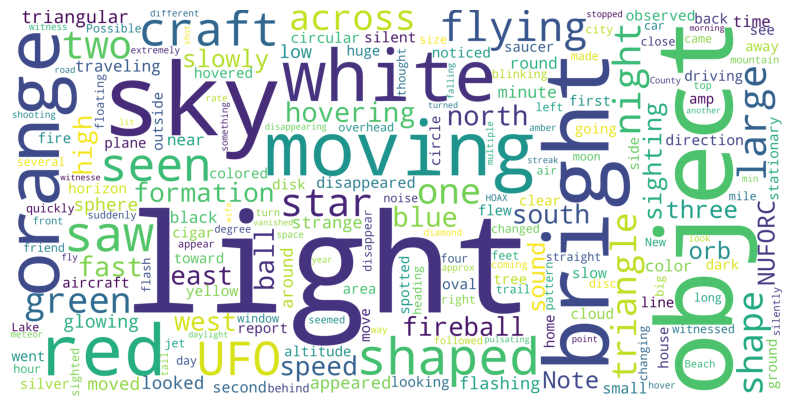

In [21]:
display_wc(wordcloud=wordcloud)
plt.show()

From a "technical" perspective, it is very satisfying: the words are not too similar, and quite relevant with respect to the UFO theme!

However, the word cloud here is "raw" in the sense that we have not yet customized its visual appearance. We can add a special mask, and generate appropriate colors based on our mask. In our case, it seems rather logical to select an image of a UFO and use it as a mask:

In [22]:
from PIL import Image
from wordcloud import ImageColorGenerator

In [23]:
ufo_mask = np.array(Image.open("pictures/ufo_coloring.jpeg"))
colors = ImageColorGenerator(ufo_mask)

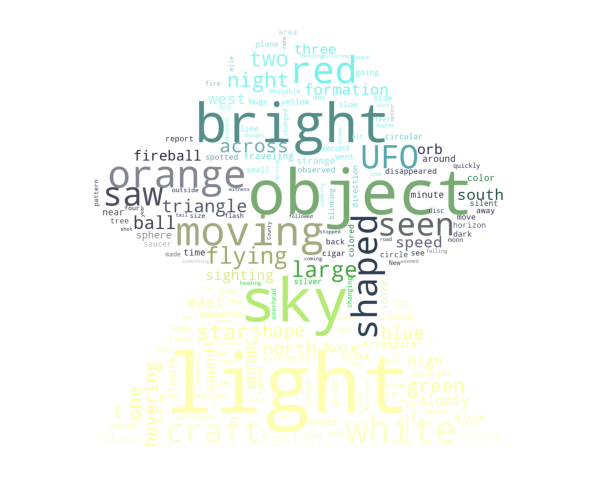

In [25]:
wordcloud = mywc(df=df, col="comments",
                 words_update=['39s', 'quot'],
                 mask=ufo_mask,
                 colors=colors)

display_wc(wordcloud=wordcloud)
plt.show()

We found that it looks better. Some words aren't visible in this notebook, but it will look even more readable in our webapp (we will also modify the background colour).

Besides, you can build your own wordcloud within our webapp (it will modify accordingly to your filter, in a few seconds)!

# 4) Non-supervised learning: Clustering

In [256]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import folium

In [264]:
from functions_model import my_scatter, map_kmeans

Since we do not have a target (Y) in our dataset, we obviously have to use non-supervised machine learning method to further analyse our data (supervised methods such as classification or regression require a target). The idea here is especially to use clustering method, because it is quite natural to use with geographical data, this way, we will be able to visualize our clusters on a map.

However, we cannot use these methods on our current dataset, because it is currently panel data: we have many observations for the same city/state/country at many periods. Thus, we need to aggregate our data. In fact, we will group our data by US states. This implies to get rid of other countries: we are perfectly aware that it is a limitation of our model. However, most of the data in the dataset is US-based, so it is not that problematic to reduce the scope of our analysis.

In [267]:
df1 = df.copy()
df1 = df1.loc[df1["country"] == 'united states of america (the)'] # only US data

## 4.1) Feature engineering

Before embarking on modeling, we need to make our data usable: this requires further preprocessing, in addition to what we have already done in part 1).

First, we see that the shape of the UFO is very detailled, but thus it is very sparse:

In [268]:
df1["shape"].value_counts()

light        14633
triangle      7078
circle        6594
fireball      5564
unknown       4987
other         4906
sphere        4747
disk          4538
oval          3292
formation     2168
cigar         1796
changing      1738
flash         1168
rectangle     1158
cylinder      1135
diamond       1018
chevron        871
egg            644
teardrop       642
cone           268
cross          202
delta            6
crescent         2
round            2
dome             1
pyramid          1
flare            1
hexagon          1
changed          1
Name: shape, dtype: int64

Hence, we need to group some modalities. We choose the regrouping below:

In [269]:
# creating groups from the modalities of the UFO shape
light = ["light", "flash", "fireball", "flare"]
flat = ["disk", "circle", "triangle", "diamond", "chevron", "rectangle", "cross",
        "round", "hexagon"]
volumetric = ["sphere", "egg", "oval", "cone", "teardrop", "cylinder", "pyramid", "dome", "cigar"]
other = list(set(df1.loc[~(df1["shape"].isin(light) | df1["shape"].isin(flat) | df1["shape"].isin(volumetric))]['shape']))

We did the regrouping following our intuition and logic. In the end, it remains only 4 modalities, which is way more usable than 30 modalities.

In [270]:
# replacing former modalities of the shape by the new ones
df1["kmshape"] = df1["shape"].replace(dict.fromkeys(light, 'light'))
df1["kmshape"] = df1["kmshape"].replace(dict.fromkeys(flat, 'flat'))
df1["kmshape"] = df1["kmshape"].replace(dict.fromkeys(volumetric, 'volumetric'))
df1["kmshape"] = df1["kmshape"].replace(dict.fromkeys(other, 'other'))

In [271]:
df1["kmshape"].value_counts()

flat          21462
light         21366
other         15539
volumetric    12526
Name: kmshape, dtype: int64

Besides, we see that the new groups are less sparse, in the sense that they are homogeneously distributed in the population.

Then, we can finally count the number of sightings by shape (based on the new modalities) and by state. Note that we normalized the count of the shape by getting the proportion, so as to remove the size effect (in terms of difference in total number of sightings by state):

In [272]:
# count the number of sightings for a shape by state, in percentage
gr = df1.groupby("state")["kmshape"].value_counts(
    normalize =True).to_frame("count").reset_index()

# Reshape dataframe from long to wide
df_wide = pd.pivot(gr, index='state', columns = 'kmshape', values = 'count')

# Re-arange the new columns in the correct order
cols = gr['kmshape'].unique()

# were the percentage of sightings for a shape is "NaN", it means 0, so let's fill it
df_wide = df_wide[cols].fillna(0).reset_index()

Then, let's get some new features for our model: the count of sightings, the median time of the sighting duration and the number of different shapes seen (all by state):

In [273]:
# count of sightings by state
to_merge = df1.value_counts("state").to_frame("count").reset_index()
df_wide = pd.merge(df_wide, to_merge, how="inner", on="state")

# median time of the sighting duration by state
to_merge = df1.groupby("state")["duration_seconds"].median().to_frame("median").reset_index()
df_wide = pd.merge(df_wide, to_merge, how="inner", on="state")

# number of different shapes seen by state
to_merge= df1.groupby("state")["shape"].nunique().to_frame("n_shape").reset_index()
df_wide = pd.merge(df_wide, to_merge, how="inner", on="state")

In [274]:
df_wide.head()

,state,flat,light,other,volumetric,count,median,n_shape
0,alabama,0.330409,0.290936,0.190058,0.188596,684,180.0,21
1,alaska,0.269886,0.363636,0.187500,0.178977,352,300.0,19
2,arizona,0.273539,0.311872,0.245999,0.168590,2687,300.0,21
3,arkansas,0.352496,0.288956,0.202723,0.155825,661,180.0,21
4,california,0.309234,0.298431,0.221460,0.170874,9627,180.0,23


We could have added more and more features to our model. However, we need to keep it short if we want to interpret our clusters correctly!

In [275]:
df_wide.shape

(51, 8)

## 4.2) KMeans Clustering

In summary, we have will fit our model using 51 US states and 7 features:
- Number of reports
- Diversity of shape seen (count of the different shapes)
- Median time of sightings
- Proportion of different shapes: flat, light, volumetric and others.

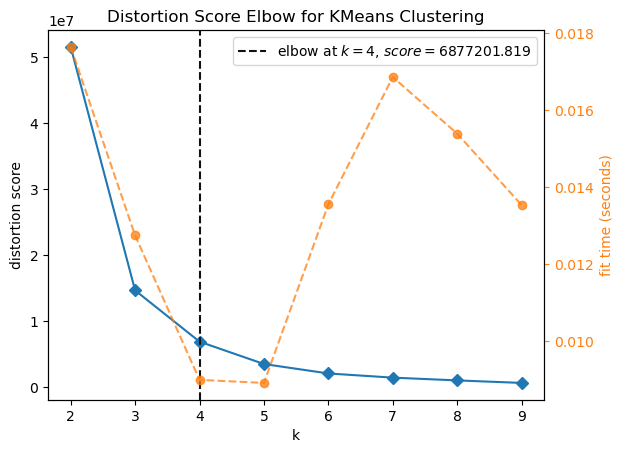

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [277]:
# we fit our KMeans model by choosing 2 to 9 clusters
km = KMeans(random_state=42) #seed=42
visualizer = KElbowVisualizer(km, k=(2,10))
 
# Fit the data to the visualizer
visualizer.fit(df_wide.drop("state", axis=1))
visualizer.show()

In order to choose the right number of clusters, we use the elbow method. This method is essentially visual, it is a heuristic method (but it remains quite reliable in general). Here, we want to determine the right bias-variance trade-off, i.e. the number of clusters that best fits the data while avoiding overfitting. It seems that 4 clusters are optimal !

### Silhouette Score

In [278]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))

for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    ax[q-1][mod].set_title("k = " + str(i))
    visualizer.fit(df_wide.drop("state", axis=1)) 

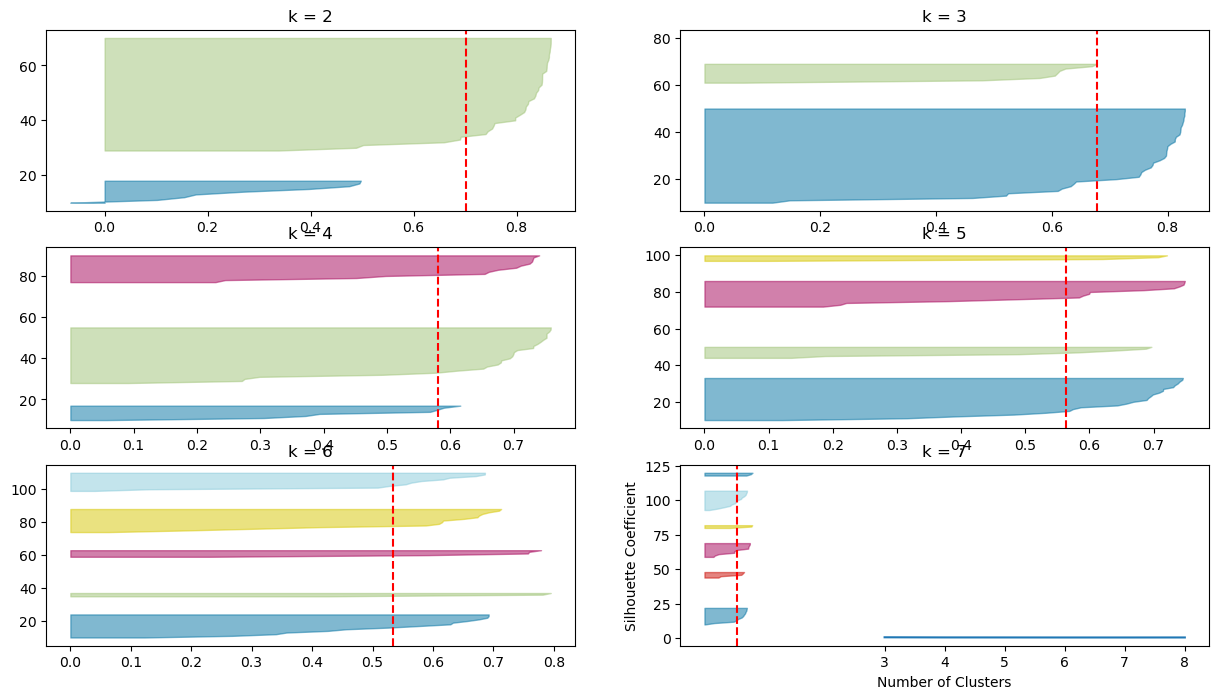

In [279]:
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(3, 9):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_wide.drop("state", axis=1))
    score = silhouette_score(df_wide.drop("state", axis=1), kmeans.labels_)
    silhouette_coefficients.append(score)

plt.plot(range(3, 9), silhouette_coefficients)
plt.xticks(range(3, 9))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

## Hierarchical Clustering

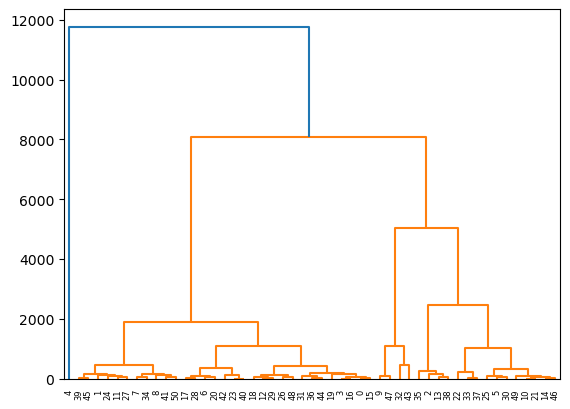

In [280]:
linkage_data = linkage(df_wide.drop("state", axis=1), method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.show()

## Interpretation of the clustering

In [281]:
model = KMeans(n_clusters=6, random_state=42).fit(df_wide.drop("state", axis=1))
df_wide['group'] = model.labels_

In [282]:
df_wide.sort_values("group").head()

,state,flat,light,other,volumetric,count,median,n_shape,group
0,alabama,0.330409,0.290936,0.190058,0.188596,684,180.0,21,0
23,minnesota,0.330250,0.291397,0.215541,0.162812,1081,180.0,22,0
36,oklahoma,0.296345,0.292428,0.240209,0.171018,766,180.0,21,0
20,maryland,0.315038,0.268935,0.221734,0.194292,911,180.0,19,0
19,maine,0.319115,0.315956,0.172196,0.192733,633,300.0,20,0


In [283]:
print(df_wide["group"].value_counts())

0    15
4    15
5    12
3     5
1     3
2     1
Name: group, dtype: int64


One state is alone (California): this is probably because the variable "count" is very discriminating for this observation: it takes a relatively high value.

In [291]:
def my_scatter(ax, x, y):
    """Generating quickly a scatterplot with seaborn"""
    sns.scatterplot(ax=ax, data=df_wide, x=x, y=y, hue='group', palette="deep")

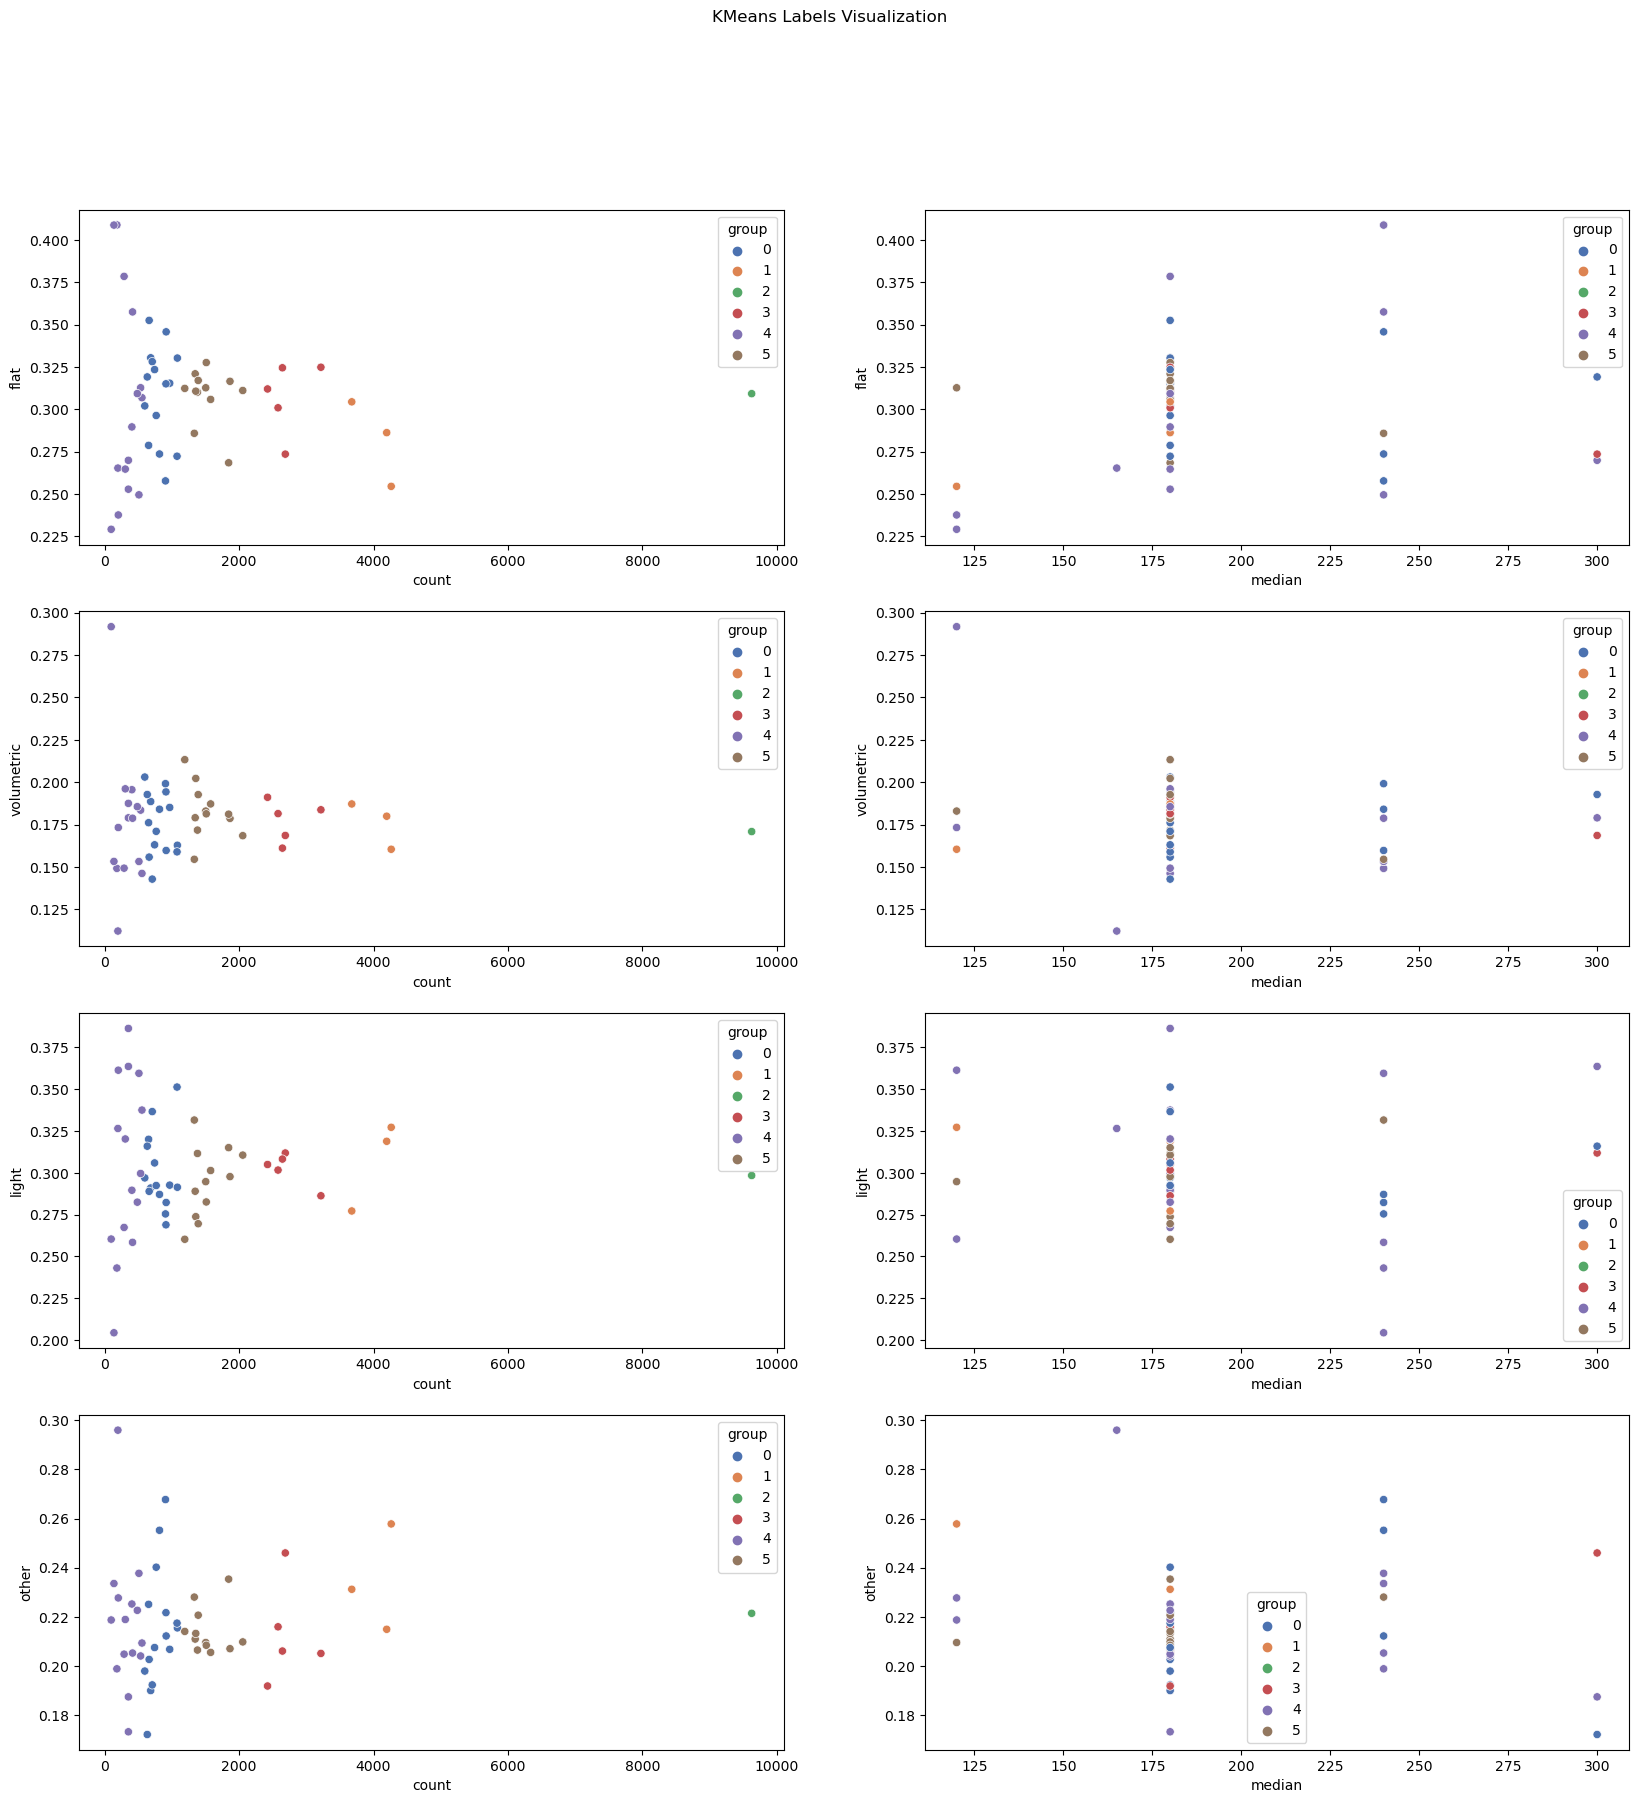

In [292]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

fig.suptitle('KMeans Labels Visualization')

my_scatter(axes[0, 0], x='count', y='flat')
my_scatter(axes[0, 1], x='median', y='flat')
my_scatter(axes[1, 0], x='count', y='volumetric')
my_scatter(axes[1, 1], x='median', y='volumetric')
my_scatter(axes[2, 0], x='count', y='light')
my_scatter(axes[2, 1], x='median', y='light')
my_scatter(axes[3, 0], x='count', y='other')
my_scatter(axes[3, 1], x='median', y='other')

plt.show()

The clusters are well defined when we look at the intersection between the "count" variable and the other variables. It is less the case with the "median" variable, because there are less modalities. We see that indeed, the state california is often alone, at the right of the chart, which justify its cluster.

In [293]:
# commenter un peu plus, fonction dans un py, merger les notebooks

In [294]:
map_kmeans(df_wide)